# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 7  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

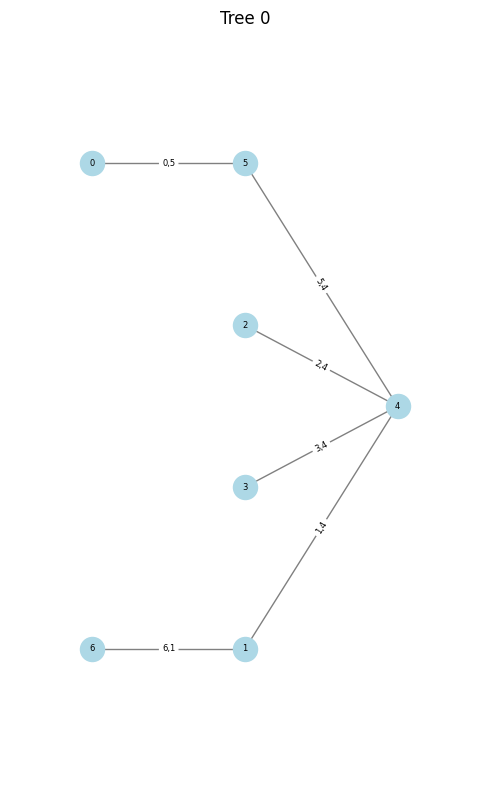

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [ ]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-10 16:45:17,776] A new study created in RDB with name: no-name-a80df472-9885-4d53-9296-70d0eda0b08b


  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<10:43,  3.11it/s]

current_loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4272902011871338
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.424118995666504
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4146559238433838
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:02, 16.27it/s]

current_loss: tensor(2.0041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4121438264846802
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4111101627349854
current_loss: tensor(1.4163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4106272459030151
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.410435438156128
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0

  1%|          | 15/2000 [00:00<01:21, 24.47it/s]

tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4104732275009155
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4102873802185059
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4103188514709473
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4105273485183716
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.410329818725586
current_loss: tensor(1.4149, device='cuda:0'

  1%|          | 21/2000 [00:01<01:13, 26.81it/s]

current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4101721048355103
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4101659059524536
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.410226821899414
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4102210998535156
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4102466106414795
current_loss: tensor(1.4148, d

  1%|          | 21/2000 [00:01<01:41, 19.43it/s]


current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4102323055267334
Early Stop at iteration 21 with minimal loss tensor(1.4102, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4165, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<05:52,  5.67it/s]

current_loss: tensor(1.4044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3113852739334106
current_loss: tensor(1.3161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1946104764938354
current_loss: tensor(1.2096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1587, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:56, 11.28it/s]

current_loss_val:  1.1411725282669067
current_loss: tensor(1.1587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1337214708328247
current_loss: tensor(1.1493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.121463656425476
current_loss: tensor(1.1342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1123, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:51, 11.64it/s]

current_loss_val:  1.09865403175354
current_loss: tensor(1.1123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0847878456115723
current_loss: tensor(1.1025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0736749172210693
current_loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:38, 12.54it/s]

current_loss: tensor(1.0889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0650478601455688
current_loss: tensor(1.0889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0558582544326782
current_loss: tensor(1.0819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0830, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:41, 12.35it/s]

current_loss: tensor(1.0765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0487565994262695


  1%|          | 13/2000 [00:01<02:32, 13.01it/s]

current_loss: tensor(1.0765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0433663129806519
current_loss: tensor(1.0725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0394301414489746
current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0359060764312744


  1%|          | 15/2000 [00:01<02:28, 13.34it/s]

current_loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0172793865203857
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.011712670326233
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:25, 13.63it/s]

current_loss: tensor(1.0344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0094504356384277


  1%|          | 19/2000 [00:01<02:22, 13.90it/s]

current_loss: tensor(1.0344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0076543092727661
current_loss: tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0018508434295654
current_loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0052754878997803


  1%|          | 21/2000 [00:01<02:21, 14.01it/s]

current_loss: tensor(1.0223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9984261989593506
current_loss: tensor(1.0162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9969580173492432
current_loss: tensor(1.0145, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:19, 14.15it/s]

current_loss: tensor(1.0126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.995307981967926


  1%|▏         | 25/2000 [00:01<02:18, 14.25it/s]

current_loss: tensor(1.0126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9942426085472107
current_loss: tensor(1.0114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9936195611953735
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.992974042892456


  1%|▏         | 27/2000 [00:02<02:18, 14.24it/s]

current_loss: tensor(1.0093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9926971793174744
current_loss: tensor(1.0088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9922269582748413
current_loss: tensor(1.0074, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:18, 14.21it/s]

current_loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9921810626983643


  2%|▏         | 31/2000 [00:02<02:17, 14.31it/s]

current_loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9922175407409668
current_loss: tensor(1.0052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9938094019889832
current_loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9924622774124146


  2%|▏         | 33/2000 [00:02<02:18, 14.24it/s]

current_loss: tensor(1.0029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9919387698173523
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9902780055999756
current_loss: tensor(1.0020, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:17, 14.25it/s]

current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9898936748504639


  2%|▏         | 37/2000 [00:02<02:16, 14.33it/s]

current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9897903203964233
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9895179271697998
current_loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9893128275871277


  2%|▏         | 39/2000 [00:02<02:26, 13.37it/s]

current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887298941612244
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9882799386978149
current_loss: tensor(0.9983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:20, 13.90it/s]

current_loss_val:  0.9867449402809143
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9852344393730164
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9834370613098145
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:20, 13.95it/s]

current_loss_val:  0.9809714555740356
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9803603291511536
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9774304032325745
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:19, 13.98it/s]

current_loss_val:  0.9749553203582764
current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747010469436646
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748644828796387


  2%|▏         | 49/2000 [00:03<02:20, 13.92it/s]

current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:25, 13.37it/s]

current_loss_val:  0.9749528765678406
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755483269691467
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754765033721924
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:27, 13.16it/s]


current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975356936454773
Early Stop at iteration 52 with minimal loss tensor(0.9747, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:45:29,725] Trial 0 finished with value: -6.822907447814941 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.445776079392084, 'penalty_decorrelation_ridge_second_difference': 10.603566415523073}. Best is trial 0 with value: -6.822907447814941.
  0%|          | 2/2000 [00:00<02:21, 14.15it/s]

current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754766821861267
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746224880218506
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743819832801819


  0%|          | 6/2000 [00:00<02:19, 14.32it/s]

current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9741085171699524
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743427634239197
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736821055412292


  0%|          | 8/2000 [00:00<02:18, 14.38it/s]

current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730277061462402
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727983474731445
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9718912839889526


  0%|          | 10/2000 [00:00<02:18, 14.36it/s]

current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692191481590271
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968734085559845
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:24, 13.71it/s]

current_loss_val:  0.9683967232704163
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9668896198272705
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656072854995728
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:22, 13.90it/s]

current_loss_val:  0.9648094177246094
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9643518924713135
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961152195930481
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:32, 13.02it/s]

current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9604128003120422
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9596598148345947
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9593687653541565


  1%|          | 22/2000 [00:01<02:27, 13.41it/s]

current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589258432388306
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958554744720459
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580739140510559


  1%|▏         | 26/2000 [00:01<02:21, 13.93it/s]

current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957538366317749
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573850631713867
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572864174842834


  1%|▏         | 28/2000 [00:02<02:20, 14.04it/s]

current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568752646446228
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559825658798218
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:26, 13.43it/s]

current_loss_val:  0.95560222864151
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550682902336121
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9546085000038147
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:23, 13.70it/s]

current_loss_val:  0.9539264440536499
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95334792137146
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952982485294342
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:21, 13.88it/s]

current_loss_val:  0.9528526663780212
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527145028114319
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526020884513855


  2%|▏         | 40/2000 [00:03<03:00, 10.88it/s]

current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525684714317322
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952704668045044
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528493285179138


  2%|▏         | 42/2000 [00:03<02:33, 12.72it/s]

current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95276939868927
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526818990707397
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526691436767578
Early Stop at iteration 42 with minimal loss tensor(0.9526, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:45:34,475] Trial 1 finished with value: -6.667979717254639 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.8233814172761873, 'penalty_decorrelation_ridge_second_difference': 3.316608622210164}. Best is trial 1 with value: -6.667979717254639.
  0%|          | 2/2000 [00:00<02:21, 14.14it/s]

current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756852388381958
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748916029930115
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747125506401062


  0%|          | 6/2000 [00:00<02:22, 14.02it/s]

current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746053218841553
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756602644920349
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749562740325928


  0%|          | 8/2000 [00:00<02:20, 14.17it/s]

current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.97458416223526
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9744256138801575
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739686250686646


  0%|          | 10/2000 [00:00<02:28, 13.36it/s]

current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732265472412109
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9728490114212036
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9808, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:22, 13.92it/s]

current_loss_val:  0.9725714325904846
current_loss: tensor(0.9808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725649952888489
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725844860076904
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:21, 13.98it/s]

current_loss_val:  0.9726760387420654
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727086424827576
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725325107574463
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:19, 14.21it/s]

current_loss_val:  0.9723548889160156
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9723180532455444
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721810817718506
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:18, 14.23it/s]

current_loss_val:  0.971807599067688
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717368483543396
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717222452163696
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:17, 14.37it/s]

current_loss_val:  0.9716789722442627
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715924263000488
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715909361839294
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:24, 13.66it/s]

current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9718698263168335
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715433716773987
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710530042648315
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:27, 13.34it/s]

current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9697787761688232
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684528112411499
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9675207734107971


  2%|▏         | 34/2000 [00:02<02:24, 13.64it/s]

current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659264087677002
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9650687575340271
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9644473791122437


  2%|▏         | 38/2000 [00:02<02:20, 14.00it/s]

current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9634768962860107
current_loss: tensor(0.9713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9618120789527893
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605069756507874


  2%|▏         | 40/2000 [00:02<02:19, 14.10it/s]

current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.959598958492279
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958976149559021
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584037065505981


  2%|▏         | 42/2000 [00:03<02:26, 13.37it/s]

current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957867443561554
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566115736961365
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:28, 13.20it/s]

current_loss_val:  0.9545498490333557
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540693163871765
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9539344310760498
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:24, 13.50it/s]

current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530983567237854
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528692960739136
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528603553771973
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:24, 13.46it/s]

current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527372717857361
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526277184486389
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526042938232422


  3%|▎         | 54/2000 [00:03<02:36, 12.47it/s]

current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952635645866394
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520497918128967
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:30, 12.96it/s]

current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520106911659241
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522367119789124
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522222280502319


  3%|▎         | 58/2000 [00:04<02:32, 12.73it/s]

current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522140026092529
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522743821144104
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:26, 13.29it/s]


current_loss_val:  0.9522808194160461
Early Stop at iteration 59 with minimal loss tensor(0.9520, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:45:40,420] Trial 2 finished with value: -6.6640753746032715 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.301306479359125, 'penalty_decorrelation_ridge_second_difference': 11.346326095838032}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:21, 14.14it/s]

current_loss: tensor(1.0250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750771522521973
current_loss: tensor(1.0229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9774501919746399
current_loss: tensor(1.0186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9790019392967224


  0%|          | 5/2000 [00:00<02:47, 11.94it/s]

current_loss: tensor(1.0147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9808536171913147
current_loss: tensor(1.0141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9790425300598145
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9784023761749268
Early Stop at iteration 5 with minimal loss tensor(0.9751, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:45:42,936] Trial 3 finished with value: -6.825540065765381 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.219976117728137, 'penalty_decorrelation_ridge_second_difference': 27.146293495306647}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:49, 11.77it/s]

current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9753022789955139
current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752236008644104
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9818, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:31, 13.15it/s]

current_loss_val:  0.9755236506462097
current_loss: tensor(0.9818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9767042398452759
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9762691259384155
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:52, 11.53it/s]

current_loss_val:  0.9758093953132629
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754667282104492
Early Stop at iteration 6 with minimal loss tensor(0.9752, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:45:45,235] Trial 4 finished with value: -6.826565265655518 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.556359471975585, 'penalty_decorrelation_ridge_second_difference': 24.667303743026995}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:20, 14.23it/s]

current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755988717079163
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747400283813477
current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745528101921082


  0%|          | 6/2000 [00:00<02:19, 14.28it/s]

current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974368691444397
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974700927734375
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743024706840515


  0%|          | 8/2000 [00:00<02:19, 14.31it/s]

current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739943146705627
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742518067359924
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735845327377319


  0%|          | 10/2000 [00:00<02:31, 13.16it/s]

current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972395658493042
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716238975524902
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:27, 13.50it/s]

current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712938070297241
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711728692054749
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712600111961365
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:28, 13.37it/s]

current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711235761642456
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9706984162330627
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:43, 12.13it/s]

current_loss_val:  0.9703193306922913
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9701002836227417
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692763090133667
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:31, 13.08it/s]

current_loss_val:  0.9684503078460693
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684047102928162
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968133807182312
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:27, 13.43it/s]

current_loss_val:  0.9680954813957214
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682925343513489
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684628248214722
current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:31, 13.00it/s]

current_loss_val:  0.9684236645698547
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684348106384277
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685648679733276
Early Stop at iteration 27 with minimal loss tensor(0.9681, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:45:48,920] Trial 5 finished with value: -6.776669025421143 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.42595027889244, 'penalty_decorrelation_ridge_second_difference': 5.101523160943989}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:17, 14.51it/s]

current_loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755128026008606
current_loss: tensor(0.9922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750750660896301
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750903844833374


  0%|          | 4/2000 [00:00<02:17, 14.56it/s]

current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754450917243958
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757636785507202
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:49, 11.75it/s]

current_loss_val:  0.9756237268447876
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750810265541077
Early Stop at iteration 6 with minimal loss tensor(0.9751, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:45:51,744] Trial 6 finished with value: -6.825525283813477 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.729781558473347, 'penalty_decorrelation_ridge_second_difference': 14.1397154502284}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:20, 14.22it/s]

current_loss: tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757195711135864
current_loss: tensor(0.9988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749671816825867
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748094081878662


  0%|          | 6/2000 [00:00<02:19, 14.33it/s]

current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747745990753174
current_loss: tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9763670563697815
current_loss: tensor(0.9964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756228923797607


  0%|          | 8/2000 [00:00<02:18, 14.36it/s]

current_loss: tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752512574195862
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752073287963867
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747441411018372


  0%|          | 10/2000 [00:00<02:28, 13.42it/s]

current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746082425117493
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743062257766724
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:22, 13.95it/s]

current_loss_val:  0.9740728139877319
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9740467071533203
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974108099937439
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:22, 13.96it/s]

current_loss_val:  0.9745503664016724
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747491478919983
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745012521743774
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9901, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:31, 13.11it/s]


current_loss_val:  0.97423255443573
Early Stop at iteration 17 with minimal loss tensor(0.9740, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:45:54,851] Trial 7 finished with value: -6.818326950073242 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.17496139116514, 'penalty_decorrelation_ridge_second_difference': 2.7628839289784697}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:21, 14.17it/s]

current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754349589347839
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750069379806519
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750030636787415


  0%|          | 4/2000 [00:00<02:18, 14.38it/s]

current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752838611602783
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9753051400184631
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.89it/s]

current_loss_val:  0.975008487701416
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732978940010071
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9731577634811401
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.33it/s]

current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9728988409042358
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725755453109741
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721449613571167
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:25, 13.67it/s]

current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9724007844924927
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9718025326728821
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715175628662109
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:22, 13.93it/s]

current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712442755699158
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9703805446624756
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694505929946899
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:19, 14.15it/s]

current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694136381149292
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693958759307861
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692720174789429
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:20, 14.12it/s]

current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691025018692017
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680532813072205
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677894711494446


  1%|          | 24/2000 [00:01<02:29, 13.19it/s]

current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676773548126221
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670997262001038
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:33, 12.86it/s]

current_loss_val:  0.9670904874801636
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9666223526000977
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:40, 12.27it/s]

current_loss_val:  0.9660987854003906
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659870862960815
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659225344657898
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:33, 12.81it/s]

current_loss_val:  0.9657803773880005
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659652709960938
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9657831788063049
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:24, 13.59it/s]

current_loss_val:  0.9657527208328247
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9657474756240845
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659734964370728
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:22, 13.76it/s]

current_loss_val:  0.9657834768295288
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656293392181396
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.965446412563324
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:25, 13.46it/s]

current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9653850197792053
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9652713537216187
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9648187756538391
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:30, 13.02it/s]

current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9638980031013489
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9619213342666626
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9597060680389404


  2%|▏         | 46/2000 [00:03<02:26, 13.30it/s]

current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575245976448059
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955634593963623
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:36, 12.47it/s]

current_loss_val:  0.9545472860336304
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532406330108643
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523077607154846
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:40, 12.15it/s]

current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522415399551392
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520038962364197
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951440691947937


  3%|▎         | 56/2000 [00:04<02:26, 13.26it/s]

current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515599608421326
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513979554176331
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513695240020752


  3%|▎         | 58/2000 [00:04<02:22, 13.66it/s]

current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515069723129272
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514946937561035
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:31, 12.79it/s]

current_loss_val:  0.951222836971283
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513207077980042
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951259970664978
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:04<02:29, 12.94it/s]

current_loss_val:  0.951383650302887
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951532244682312
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516123533248901
Early Stop at iteration 63 with minimal loss tensor(0.9512, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:46:01,460] Trial 8 finished with value: -6.658560752868652 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.8115511597689493, 'penalty_decorrelation_ridge_second_difference': 20.703998218669845}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 2/2000 [00:00<02:22, 14.01it/s]

current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754675030708313
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746196269989014
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743735194206238


  0%|          | 6/2000 [00:00<02:20, 14.16it/s]

current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9740960001945496
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743810296058655
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736766815185547


  0%|          | 8/2000 [00:00<02:20, 14.19it/s]

current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730011224746704
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727173447608948
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717714786529541


  0%|          | 10/2000 [00:00<02:19, 14.22it/s]

current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692901968955994
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688135385513306
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:31, 13.10it/s]

current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683862924575806
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677395224571228
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9672162532806396
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:27, 13.42it/s]

current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.966681718826294
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9664145112037659
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658756256103516
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:23, 13.76it/s]

current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658612012863159
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9657177925109863
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9655835032463074
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:22, 13.89it/s]

current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654616713523865
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9646360278129578
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642476439476013


  1%|          | 24/2000 [00:01<02:39, 12.39it/s]

current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9637858271598816
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9620538353919983
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:42, 12.11it/s]

current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9617567658424377
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9609887003898621
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:45, 11.93it/s]

current_loss_val:  0.9603850841522217
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9598928689956665
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605250358581543
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:40, 12.26it/s]

current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.959522545337677
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9593322277069092
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590756297111511
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:34, 12.67it/s]

current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590360522270203
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589062333106995
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586359858512878


  2%|▏         | 38/2000 [00:02<02:29, 13.09it/s]

current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95853191614151
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582253098487854
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578114151954651


  2%|▏         | 42/2000 [00:03<02:24, 13.59it/s]

current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578045606613159
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578033089637756
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577553868293762


  2%|▏         | 44/2000 [00:03<02:28, 13.15it/s]

current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577875137329102
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577505588531494
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:33, 12.75it/s]

current_loss_val:  0.9577142000198364
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576826691627502
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576858282089233
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:25, 13.43it/s]

current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957716166973114
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575638771057129
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582439064979553
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:23, 13.61it/s]

current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572082757949829
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568836688995361
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9563685655593872
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:25, 13.40it/s]

current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562364816665649
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560239911079407
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9554751515388489


  3%|▎         | 58/2000 [00:04<02:22, 13.65it/s]

current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9554638862609863
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553080201148987
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955277681350708


  3%|▎         | 62/2000 [00:04<02:20, 13.84it/s]

current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552341103553772
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551886320114136
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549626111984253


  3%|▎         | 64/2000 [00:04<02:25, 13.26it/s]

current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547750949859619
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547502398490906
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:24, 13.41it/s]

current_loss_val:  0.9545940160751343
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537042379379272
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536505341529846
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:19, 13.81it/s]

current_loss_val:  0.9530495405197144
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526375532150269
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522435665130615
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:25, 13.24it/s]

current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9519862532615662
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516364932060242
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514504671096802
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:28, 12.97it/s]

current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514137506484985
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951371431350708
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513801336288452


  4%|▍         | 78/2000 [00:05<02:23, 13.36it/s]

current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514786601066589
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514440894126892
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514244198799133


  4%|▍         | 79/2000 [00:06<02:27, 13.06it/s]


current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951457142829895
Early Stop at iteration 79 with minimal loss tensor(0.9514, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:46:09,587] Trial 9 finished with value: -6.659600257873535 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.46661957873759, 'penalty_decorrelation_ridge_second_difference': 1.1337611762976592}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754169583320618


  0%|          | 4/2000 [00:00<03:49,  8.69it/s]

current_loss: tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752395749092102
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755629301071167
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9767161011695862


  0%|          | 6/2000 [00:00<03:56,  8.43it/s]

current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9762707948684692
current_loss: tensor(0.9919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9760391116142273
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975594699382782
Early Stop at iteration 6 with minimal loss tensor(0.9752, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:46:12,262] Trial 10 finished with value: -6.826676845550537 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.833255229568516, 'penalty_decorrelation_ridge_second_difference': 15.66351370645606}. Best is trial 8 with value: -6.658560752868652.


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4352, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<00:28, 34.41it/s]

current_loss: tensor(1.4352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4284, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:25, 38.49it/s]

current_loss: tensor(1.4284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<00:25, 39.05it/s]

current_loss: tensor(1.4283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:23, 41.21it/s]

current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:00<00:23, 41.27it/s]

current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  3%|▎         | 28/1000 [00:00<00:24, 39.45it/s]

current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:00<00:24, 39.33it/s]

current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:00<00:23, 40.13it/s]

current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  4%|▍         | 43/1000 [00:01<00:23, 39.88it/s]

tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:01<00:23, 40.41it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▌         | 53/1000 [00:01<00:25, 37.56it/s]

current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 58/1000 [00:01<00:24, 38.76it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:01<00:23, 39.53it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  7%|▋         | 73/1000 [00:01<00:22, 40.81it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 78/1000 [00:01<00:22, 40.96it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 83/1000 [00:02<00:26, 34.72it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  9%|▊         | 87/1000 [00:02<00:46, 19.45it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  9%|▊         | 87/1000 [00:02<00:28, 31.76it/s]

Early Stop at iteration 87 with minimal loss tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [ ]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3196, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<02:17,  7.28it/s]

current_loss_val:  1.3157579898834229
current_loss: tensor(1.3196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1785951852798462
current_loss: tensor(1.1839, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:37, 10.24it/s]

current_loss: tensor(1.3876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1463351249694824
current_loss: tensor(1.1514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1351004838943481


  0%|          | 5/1000 [00:00<01:23, 11.87it/s]

current_loss: tensor(1.1398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1071443557739258
current_loss: tensor(1.1109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1002464294433594
current_loss: tensor(1.1033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0968, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:24, 11.75it/s]

current_loss_val:  1.0946100950241089
current_loss: tensor(1.0968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0780333280563354
current_loss: tensor(1.0802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0764, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<01:23, 11.84it/s]

current_loss_val:  1.0744624137878418
current_loss: tensor(1.0764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0714693069458008
current_loss: tensor(1.0732, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<01:18, 12.56it/s]

current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0446009635925293
current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0258030891418457
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<01:15, 13.02it/s]

current_loss: tensor(1.0304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0248292684555054
current_loss: tensor(1.0304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0187262296676636
current_loss: tensor(1.0242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0224, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<01:16, 12.91it/s]

current_loss_val:  1.017313003540039
current_loss: tensor(1.0224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0204, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:17, 12.65it/s]

current_loss_val:  1.0163379907608032
current_loss: tensor(1.0204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0142176151275635
current_loss: tensor(1.0142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0141276121139526
current_loss: tensor(1.0119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:01<01:15, 13.03it/s]

current_loss_val:  1.0118974447250366
current_loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.010420322418213
current_loss: tensor(1.0081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:01<01:13, 13.32it/s]

current_loss_val:  1.0083330869674683
current_loss: tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<01:11, 13.57it/s]

current_loss_val:  1.00764799118042
current_loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0069754123687744
current_loss: tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.002677083015442
current_loss: tensor(1.0005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<01:11, 13.71it/s]

current_loss_val:  1.0008466243743896
current_loss: tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9990119338035583
current_loss: tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:02<01:15, 12.91it/s]

current_loss: tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9982182383537292
current_loss: tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9976337552070618
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:02<01:16, 12.61it/s]

current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9972805976867676
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9970589280128479


  3%|▎         | 31/1000 [00:02<01:14, 13.02it/s]

current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.996156632900238
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9954320192337036
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:02<01:17, 12.48it/s]

current_loss_val:  0.994916558265686
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9917078614234924
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:02<01:14, 12.92it/s]

current_loss_val:  0.9872995018959045
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9862400889396667
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:02<01:18, 12.34it/s]

current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9854446053504944
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9828894138336182


  4%|▍         | 39/1000 [00:03<01:15, 12.79it/s]

current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9816275238990784
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.98048996925354
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:03<01:12, 13.15it/s]

current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9797719120979309
current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9794288873672485


  4%|▍         | 43/1000 [00:03<01:11, 13.45it/s]

current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9789076447486877
current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9777505397796631


  4%|▍         | 45/1000 [00:03<01:10, 13.64it/s]

current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9766863584518433
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9762423038482666
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:03<01:09, 13.78it/s]

current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9758191108703613
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9764527082443237


  5%|▍         | 49/1000 [00:03<01:08, 13.90it/s]

current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756725430488586
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9751172065734863


  5%|▌         | 51/1000 [00:03<01:07, 13.96it/s]

current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746835231781006
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743578433990479
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:04<01:07, 14.04it/s]

current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736612439155579
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9734022617340088


  6%|▌         | 55/1000 [00:04<01:07, 14.08it/s]

current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732262492179871
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9731478691101074


  6%|▌         | 57/1000 [00:04<01:06, 14.08it/s]

current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730499386787415
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727532267570496
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:04<01:06, 14.11it/s]

current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9719456434249878
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.970697820186615


  6%|▌         | 61/1000 [00:04<01:06, 14.12it/s]

current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689039587974548
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685079455375671


  6%|▋         | 63/1000 [00:04<01:06, 14.09it/s]

current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9679355621337891
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9679595232009888
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:04<01:06, 14.16it/s]

current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684277176856995
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689423441886902


  7%|▋         | 67/1000 [00:05<01:05, 14.20it/s]

current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686018228530884
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:05<01:11, 13.04it/s]

current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684781432151794
Early Stop at iteration 67 with minimal loss tensor(0.9679, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [ ]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [ ]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.005, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2135 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2135])
sigma summary: 0.05001100152730942 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [00:45<1:56:45,  8.81s/it]

[convergence] ELBO/obs=-18.931075  smoothed=-14.703774  tol=0.005

Iteration [5/800] train=18.9311  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0526 σmin=0.0504 σmax=0.0550  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.076143  τ₁≈2.2933  τ₂≈4.5653  |  (EB targets) τ₄*≈0.70065  τ₁*≈28.553  τ₂*≈38.455
E_qf_total≈132.7159  E_qf1≈7.0032  E_qf2≈5.1795
[monitor] τ₄·E_qf≈10.11  target≈92.99 | τ₁·E_qf1≈16.06  target≈199.96 | τ₂·E_qf2≈23.65  target≈199.18
 [ELBO] per-obs=-18.931075


  1%|▏         | 10/800 [01:28<1:53:13,  8.60s/it]

[convergence] ELBO/obs=-25.777161  smoothed=-18.260606  tol=0.005

Iteration [10/800] train=25.7772  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0545 σmin=0.0510 σmax=0.0582  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059919  τ₁≈1.8162  τ₂≈3.5926  |  (EB targets) τ₄*≈0.70476  τ₁*≈29.564  τ₂*≈39.283
E_qf_total≈131.8247  E_qf1≈6.7410  E_qf2≈5.0634
[monitor] τ₄·E_qf≈7.90  target≈92.90 | τ₁·E_qf1≈12.24  target≈199.29 | τ₂·E_qf2≈18.19  target≈198.91
 [ELBO] per-obs=-25.777161


  2%|▏         | 15/800 [02:11<1:52:14,  8.58s/it]

[convergence] ELBO/obs=-32.667479  smoothed=-23.146815  tol=0.005

Iteration [15/800] train=32.6675  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0554 σmin=0.0515 σmax=0.0596  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051391  τ₁≈1.5642  τ₂≈3.088  |  (EB targets) τ₄*≈0.70799  τ₁*≈30.322  τ₂*≈40.762
E_qf_total≈131.1327  E_qf1≈6.5559  E_qf2≈4.8676
[monitor] τ₄·E_qf≈6.74  target≈92.84 | τ₁·E_qf1≈10.26  target≈198.79 | τ₂·E_qf2≈15.03  target≈198.41
 [ELBO] per-obs=-32.667479


  2%|▎         | 20/800 [02:54<1:51:47,  8.60s/it]

[convergence] ELBO/obs=-39.542112  smoothed=-28.850945  tol=0.005

Iteration [20/800] train=39.5421  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0558 σmin=0.0518 σmax=0.0601  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046149  τ₁≈1.4113  τ₂≈2.7875  |  (EB targets) τ₄*≈0.71012  τ₁*≈31.201  τ₂*≈42.713
E_qf_total≈130.6791  E_qf1≈6.3523  E_qf2≈4.6300
[monitor] τ₄·E_qf≈6.03  target≈92.80 | τ₁·E_qf1≈8.97  target≈198.20 | τ₂·E_qf2≈12.91  target≈197.76
 [ELBO] per-obs=-39.542112


  3%|▎         | 25/800 [03:37<1:51:17,  8.62s/it]

[convergence] ELBO/obs=-46.335513  smoothed=-35.024038  tol=0.005

Iteration [25/800] train=46.3355  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0564 σmin=0.0522 σmax=0.0638  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.041952  τ₁≈1.2899  τ₂≈2.5534  |  (EB targets) τ₄*≈0.71267  τ₁*≈32.353  τ₂*≈45.557
E_qf_total≈130.1405  E_qf1≈6.1024  E_qf2≈4.3202
[monitor] τ₄·E_qf≈5.46  target≈92.75 | τ₁·E_qf1≈7.87  target≈197.43 | τ₂·E_qf2≈11.03  target≈196.81
 [ELBO] per-obs=-46.335513


  4%|▍         | 30/800 [04:20<1:50:22,  8.60s/it]

[convergence] ELBO/obs=-53.255174  smoothed=-41.489631  tol=0.005

Iteration [30/800] train=53.2552  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0569 σmin=0.0524 σmax=0.0679  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03976  τ₁≈1.2271  τ₂≈2.4341  |  (EB targets) τ₄*≈0.71395  τ₁*≈33.123  τ₂*≈47.602
E_qf_total≈129.8711  E_qf1≈5.9450  E_qf2≈4.1203
[monitor] τ₄·E_qf≈5.16  target≈92.72 | τ₁·E_qf1≈7.30  target≈196.92 | τ₂·E_qf2≈10.03  target≈196.13
 [ELBO] per-obs=-53.255174


  4%|▍         | 35/800 [05:05<1:56:01,  9.10s/it]

[convergence] ELBO/obs=-60.109544  smoothed=-48.110609  tol=0.005

Iteration [35/800] train=60.1095  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0574 σmin=0.0526 σmax=0.0726  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.037643  τ₁≈1.1663  τ₂≈2.3193  |  (EB targets) τ₄*≈0.71517  τ₁*≈33.607  τ₂*≈49.125
E_qf_total≈129.6143  E_qf1≈5.8498  E_qf2≈3.9822
[monitor] τ₄·E_qf≈4.88  target≈92.70 | τ₁·E_qf1≈6.82  target≈196.60 | τ₂·E_qf2≈9.24  target≈195.62
 [ELBO] per-obs=-60.109544


  5%|▌         | 40/800 [05:48<1:50:00,  8.69s/it]

[convergence] ELBO/obs=-66.996639  smoothed=-54.838957  tol=0.005

Iteration [40/800] train=66.9966  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0580 σmin=0.0529 σmax=0.0779  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.036403  τ₁≈1.1305  τ₂≈2.2518  |  (EB targets) τ₄*≈0.71607  τ₁*≈33.938  τ₂*≈50.312
E_qf_total≈129.4274  E_qf1≈5.7862  E_qf2≈3.8803
[monitor] τ₄·E_qf≈4.71  target≈92.68 | τ₁·E_qf1≈6.54  target≈196.37 | τ₂·E_qf2≈8.74  target≈195.23
 [ELBO] per-obs=-66.996639


  6%|▌         | 45/800 [06:31<1:48:20,  8.61s/it]

[convergence] ELBO/obs=-73.821711  smoothed=-61.611565  tol=0.005

Iteration [45/800] train=73.8217  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0588 σmin=0.0531 σmax=0.0861  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035369  τ₁≈1.1005  τ₂≈2.1954  |  (EB targets) τ₄*≈0.71697  τ₁*≈34.39  τ₂*≈51.904
E_qf_total≈129.2394  E_qf1≈5.7015  E_qf2≈3.7511
[monitor] τ₄·E_qf≈4.57  target≈92.66 | τ₁·E_qf1≈6.27  target≈196.07 | τ₂·E_qf2≈8.24  target≈194.70
 [ELBO] per-obs=-73.821711


  6%|▋         | 50/800 [07:14<1:47:42,  8.62s/it]

[convergence] ELBO/obs=-80.599149  smoothed=-68.380866  tol=0.005

Iteration [50/800] train=80.5991  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0597 σmin=0.0533 σmax=0.0948  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.034421  τ₁≈1.0728  τ₂≈2.1437  |  (EB targets) τ₄*≈0.71778  τ₁*≈34.715  τ₂*≈53.208
E_qf_total≈129.0717  E_qf1≈5.6418  E_qf2≈3.6511
[monitor] τ₄·E_qf≈4.44  target≈92.64 | τ₁·E_qf1≈6.05  target≈195.86 | τ₂·E_qf2≈7.83  target≈194.26
 [ELBO] per-obs=-80.599149


  7%|▋         | 55/800 [07:57<1:47:41,  8.67s/it]

[convergence] ELBO/obs=-87.309988  smoothed=-75.150218  tol=0.005

Iteration [55/800] train=87.3100  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0606 σmin=0.0536 σmax=0.1043  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033601  τ₁≈1.0486  τ₂≈2.0986  |  (EB targets) τ₄*≈0.71851  τ₁*≈34.89  τ₂*≈54.13
E_qf_total≈128.9185  E_qf1≈5.6102  E_qf2≈3.5832
[monitor] τ₄·E_qf≈4.33  target≈92.63 | τ₁·E_qf1≈5.88  target≈195.74 | τ₂·E_qf2≈7.52  target≈193.96
 [ELBO] per-obs=-87.309988


  8%|▊         | 60/800 [08:40<1:46:20,  8.62s/it]

[convergence] ELBO/obs=-94.071385  smoothed=-81.901809  tol=0.005

Iteration [60/800] train=94.0714  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0615 σmin=0.0538 σmax=0.1143  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032785  τ₁≈1.0244  τ₂≈2.053  |  (EB targets) τ₄*≈0.7192  τ₁*≈35.022  τ₂*≈54.897
E_qf_total≈128.7774  E_qf1≈5.5866  E_qf2≈3.5284
[monitor] τ₄·E_qf≈4.22  target≈92.62 | τ₁·E_qf1≈5.72  target≈195.65 | τ₂·E_qf2≈7.24  target≈193.70
 [ELBO] per-obs=-94.071385


  8%|▊         | 65/800 [09:24<1:47:25,  8.77s/it]

[convergence] ELBO/obs=-95.218623  smoothed=-87.379450  tol=0.005

Iteration [65/800] train=95.2186  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0625 σmin=0.0540 σmax=0.1272  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031977  τ₁≈1.0002  τ₂≈2.0076  |  (EB targets) τ₄*≈0.71997  τ₁*≈35.208  τ₂*≈55.969
E_qf_total≈128.6183  E_qf1≈5.5536  E_qf2≈3.4545
[monitor] τ₄·E_qf≈4.11  target≈92.60 | τ₁·E_qf1≈5.55  target≈195.53 | τ₂·E_qf2≈6.94  target≈193.34
 [ELBO] per-obs=-95.218623


  9%|▉         | 70/800 [10:08<1:45:29,  8.67s/it]

[convergence] ELBO/obs=-94.860762  smoothed=-90.499244  tol=0.005

Iteration [70/800] train=94.8608  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0636 σmin=0.0542 σmax=0.1410  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031183  τ₁≈0.97622  τ₂≈1.9625  |  (EB targets) τ₄*≈0.72069  τ₁*≈35.287  τ₂*≈56.771
E_qf_total≈128.4682  E_qf1≈5.5396  E_qf2≈3.4010
[monitor] τ₄·E_qf≈4.01  target≈92.59 | τ₁·E_qf1≈5.41  target≈195.48 | τ₂·E_qf2≈6.67  target≈193.08
 [ELBO] per-obs=-94.860762


  9%|▉         | 75/800 [10:51<1:44:13,  8.63s/it]

[convergence] ELBO/obs=-94.687645  smoothed=-92.244650  tol=0.005

Iteration [75/800] train=94.6876  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0647 σmin=0.0544 σmax=0.1556  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030401  τ₁≈0.95248  τ₂≈1.9177  |  (EB targets) τ₄*≈0.72136  τ₁*≈35.367  τ₂*≈57.492
E_qf_total≈128.3312  E_qf1≈5.5255  E_qf2≈3.3541
[monitor] τ₄·E_qf≈3.90  target≈92.57 | τ₁·E_qf1≈5.26  target≈195.42 | τ₂·E_qf2≈6.43  target≈192.84
 [ELBO] per-obs=-94.687645


 10%|█         | 80/800 [11:34<1:43:22,  8.61s/it]

[convergence] ELBO/obs=-94.398328  smoothed=-93.186622  tol=0.005

Iteration [80/800] train=94.3983  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0658 σmin=0.0546 σmax=0.1711  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029634  τ₁≈0.92904  τ₂≈1.8732  |  (EB targets) τ₄*≈0.72198  τ₁*≈35.347  τ₂*≈58.002
E_qf_total≈128.2034  E_qf1≈5.5290  E_qf2≈3.3217
[monitor] τ₄·E_qf≈3.80  target≈92.56 | τ₁·E_qf1≈5.14  target≈195.44 | τ₂·E_qf2≈6.22  target≈192.67
 [ELBO] per-obs=-94.398328


 11%|█         | 85/800 [12:17<1:42:32,  8.60s/it]

[convergence] ELBO/obs=-94.301510  smoothed=-93.666475  tol=0.005

Iteration [85/800] train=94.3015  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0669 σmin=0.0547 σmax=0.1866  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028883  τ₁≈0.90591  τ₂≈1.8291  |  (EB targets) τ₄*≈0.72258  τ₁*≈35.343  τ₂*≈58.515
E_qf_total≈128.0803  E_qf1≈5.5297  E_qf2≈3.2897
[monitor] τ₄·E_qf≈3.70  target≈92.55 | τ₁·E_qf1≈5.01  target≈195.44 | τ₂·E_qf2≈6.02  target≈192.50
 [ELBO] per-obs=-94.301510


 11%|█▏        | 90/800 [13:00<1:43:18,  8.73s/it]

[convergence] ELBO/obs=-94.001725  smoothed=-93.835262  tol=0.005

Iteration [90/800] train=94.0017  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0680 σmin=0.0549 σmax=0.2019  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028148  τ₁≈0.88313  τ₂≈1.7854  |  (EB targets) τ₄*≈0.72313  τ₁*≈35.278  τ₂*≈58.899
E_qf_total≈127.9683  E_qf1≈5.5413  E_qf2≈3.2661
[monitor] τ₄·E_qf≈3.60  target≈92.54 | τ₁·E_qf1≈4.89  target≈195.48 | τ₂·E_qf2≈5.83  target≈192.37
 [ELBO] per-obs=-94.001725


 12%|█▏        | 94/800 [13:43<1:43:08,  8.77s/it]

[convergence] ELBO/obs=-93.853307  smoothed=-93.859582  tol=0.005
Converged (ELBO plateau) at epoch 95 with Δ<tol=0.005.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [ ]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.5069
KLD GTM      Train Data:  0.3624
KLD Gaussian Train Data:  1.2661
KLD Copula   Train Data:  -0.0015
----------------------------------------
KLD BGTM      Train Data:  0.5998
KLD GTM      Test  Data:  0.4814
KLD Gaussian Test  Data:  1.2983
KLD Copula   Test  Data:  0.0161


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [ ]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    tau_nodes=tau_nodes,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6
)

Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 17 with var_row_num 6 and var_col_num 2.
Pr

In [28]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes

CI_theta = theta_credible_intervals(VI)
tau_info = [
    ("τ₄ (transformation)", *tau_ci_from_node(tau_nodes.node4)),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", *tau_ci_from_node(tau_nodes.node1)),
        ("τ₂ (decor RW2)", *tau_ci_from_node(tau_nodes.node2)),
    ]

NotImplementedError: 

ValueError: only one element tensors can be converted to Python scalars

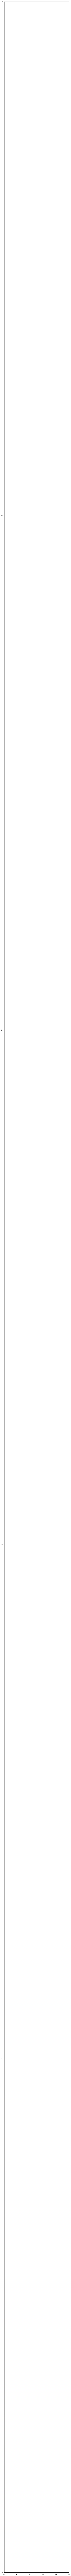

In [ ]:
plot_theta_ci((CI_theta["mu"]), CI_theta["lower"],  CI_theta["upper"])

In [ ]:
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [24]:
synthetic_samples = model.sample(2000)

[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


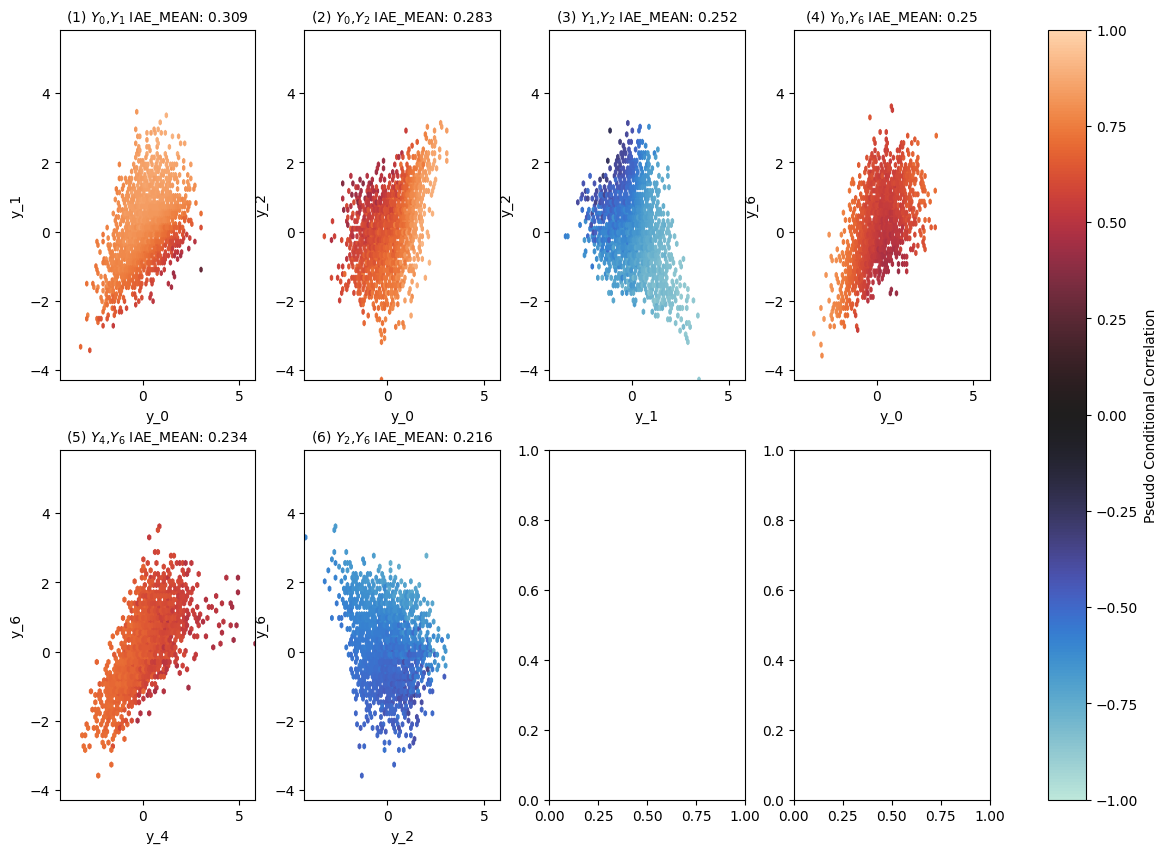

In [25]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

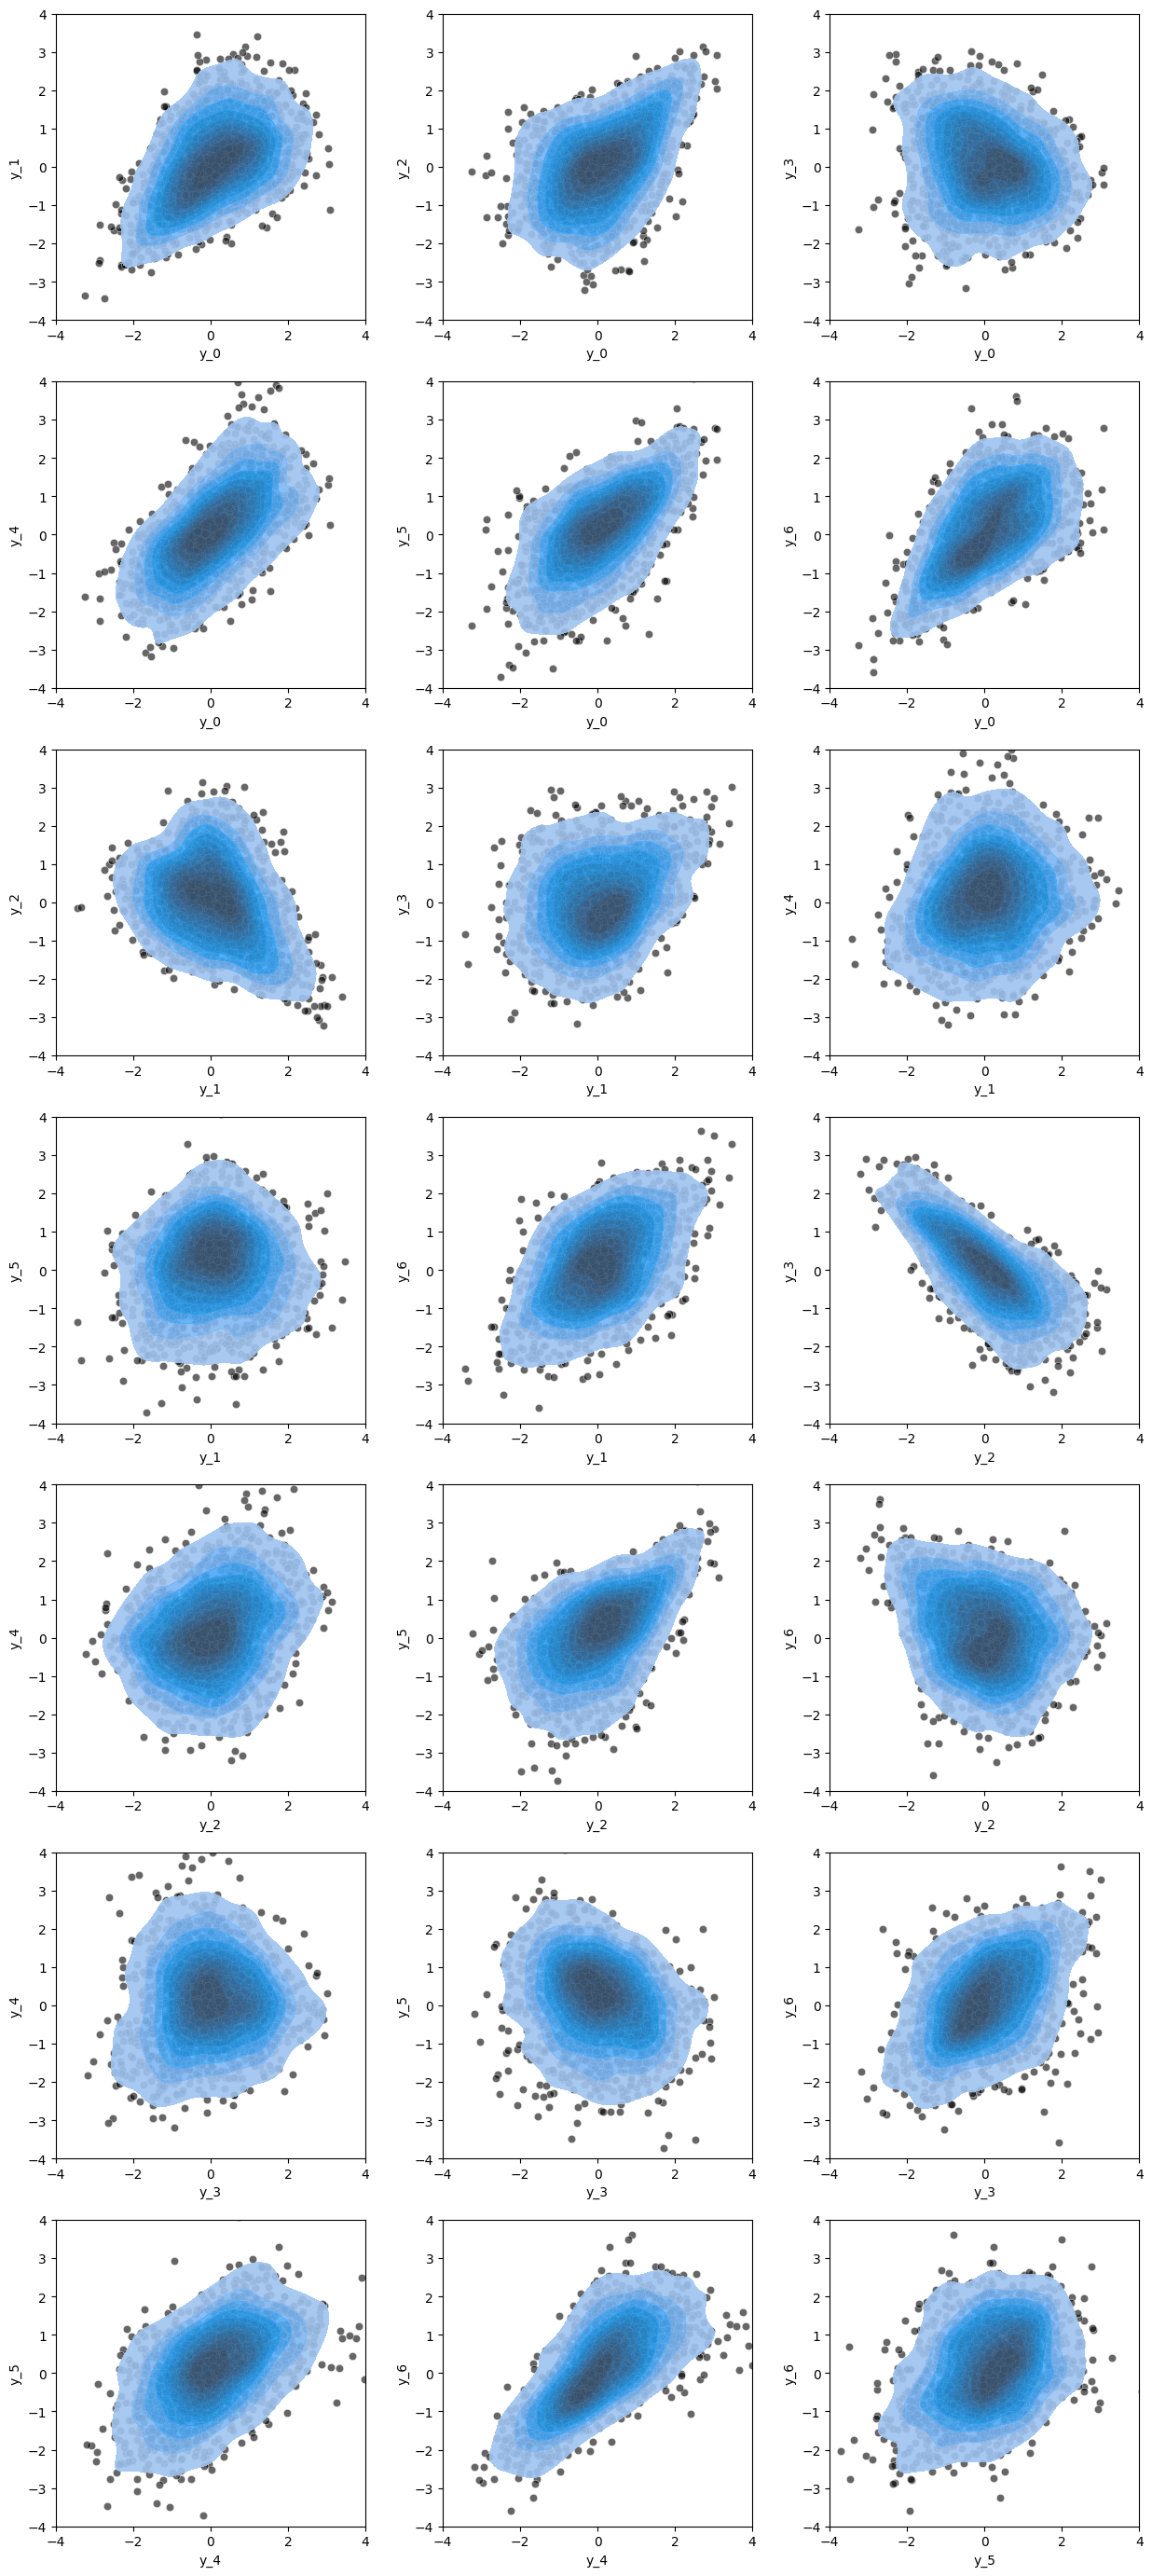

In [27]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [27]:
#model.plot_splines(layer_type="transformation")

In [28]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [29]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [30]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [28]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [32]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [29]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.977008,0.642034,-0.015584,-0.120779,-0.158442,-0.025974,-0.032468,-0.050649,-0.079221,...,-0.075325,-0.025974,-0.062338,-0.125974,-0.125974,-0.125974,-0.106494,-0.106494,-0.118182,-0.110221
var_row,0.977008,1.000000,0.471429,0.019939,-0.121628,-0.085073,-0.040543,-0.048518,-0.063805,-0.089725,...,-0.079091,-0.039213,-0.065799,-0.093713,-0.093713,-0.093713,-0.089725,-0.089725,-0.100359,-0.024175
var_col,0.642034,0.471429,1.000000,-0.217999,0.029908,-0.453943,0.146884,0.146884,0.125615,0.097036,...,-0.105676,-0.053171,-0.105012,-0.276487,-0.276487,-0.276487,-0.212682,-0.212682,-0.225975,-0.443203
abs_mean,-0.015584,0.019939,-0.217999,1.000000,-0.277922,0.854545,-0.363636,-0.380519,-0.375325,-0.333766,...,0.955844,0.941558,0.963636,0.953247,0.953247,0.953247,0.961039,0.961039,0.963636,0.629837
mean,-0.120779,-0.121628,0.029908,-0.277922,1.000000,-0.092208,0.933766,0.933766,0.942857,0.971429,...,-0.287013,-0.310390,-0.279221,-0.312987,-0.312987,-0.312987,-0.285714,-0.285714,-0.272727,-0.251935
std,-0.158442,-0.085073,-0.453943,0.854545,-0.092208,1.000000,-0.292208,-0.310390,-0.287013,-0.200000,...,0.780519,0.728571,0.779221,0.864935,0.864935,0.864935,0.850649,0.850649,0.866234,0.740058
min,-0.025974,-0.040543,0.146884,-0.363636,0.933766,-0.292208,1.000000,0.990909,0.983117,0.957143,...,-0.335065,-0.336364,-0.322078,-0.390909,-0.390909,-0.390909,-0.348052,-0.348052,-0.346753,-0.330664
q_1,-0.032468,-0.048518,0.146884,-0.380519,0.933766,-0.310390,0.990909,1.000000,0.996104,0.970130,...,-0.359740,-0.350649,-0.346753,-0.412987,-0.412987,-0.412987,-0.377922,-0.377922,-0.375325,-0.377902
q_5,-0.050649,-0.063805,0.125615,-0.375325,0.942857,-0.287013,0.983117,0.996104,1.000000,0.976623,...,-0.364935,-0.349351,-0.349351,-0.411688,-0.411688,-0.411688,-0.374026,-0.374026,-0.370130,-0.362156
q_10,-0.079221,-0.089725,0.097036,-0.333766,0.971429,-0.200000,0.957143,0.970130,0.976623,1.000000,...,-0.323377,-0.322078,-0.312987,-0.354545,-0.354545,-0.354545,-0.332468,-0.332468,-0.322078,-0.330664


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [30]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.9090909090909092
AUC KLD                    : 0.9090909090909092
AUC Conditional Correlation: 0.8363636363636364
AUC Precision Matrix       : 0.8818181818181818


We further print the ROC Curves for different metrics.

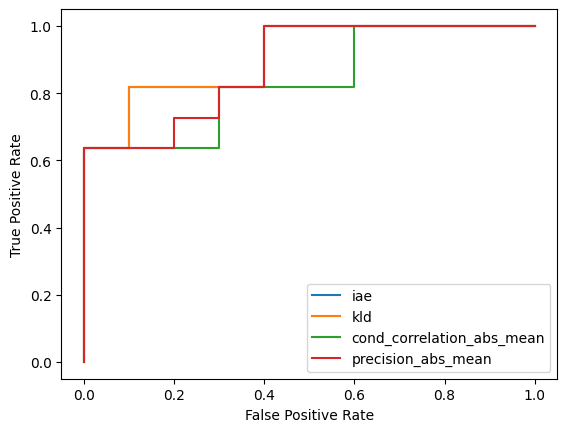

In [31]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()